# Image Captioning Neural Model (SC4001)

In [1]:
!pip install pillow opencv-python pydot


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!brew install graphviz

'brew' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
import os
from PIL import Image
import cv2
import random
from textwrap import wrap

import math
import pickle

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydot

import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, Add, Concatenate, Reshape, concatenate, Bidirectional, RepeatVector
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras.regularizers import l2

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### 1.1 Retrieving the datasets

In [9]:
captions = pd.read_csv('./flickr8k_images/captions.txt', delimiter=',')
image_path = './flickr8k_images/Images'
images = os.listdir(image_path)

valid_imgExt = [".jpg", ".jpeg", ".png"]

image_size = [(64, 64), (128, 128), (224, 224), (256, 256)]

# We will first use (224, 244) image size

def show_images(num, images):
    plt.figure(figsize=(25, 25))

    # Randomly select images
    r = random.randint(0, len(images)-num-1)

    for i, filename in enumerate(images[r:r+num]):
        if os.path.splitext(filename)[1].lower() not in valid_imgExt:
            continue
        with open(os.path.join(image_path, filename), 'rb') as img:
            img = Image.open(img).resize(image_size[2])
            plt.subplot(5, 5, i+1)
            plt.imshow(img)
            plt.title("\n".join(wrap(get_caption(filename, captions), 20)))
            plt.subplots_adjust(hspace=0.8)
            img.close()

    plt.show()

def get_caption(filename, captions):
    cap = captions[captions['image'] == filename]['caption'].values
    return cap[random.randint(0, len(cap)-1)]

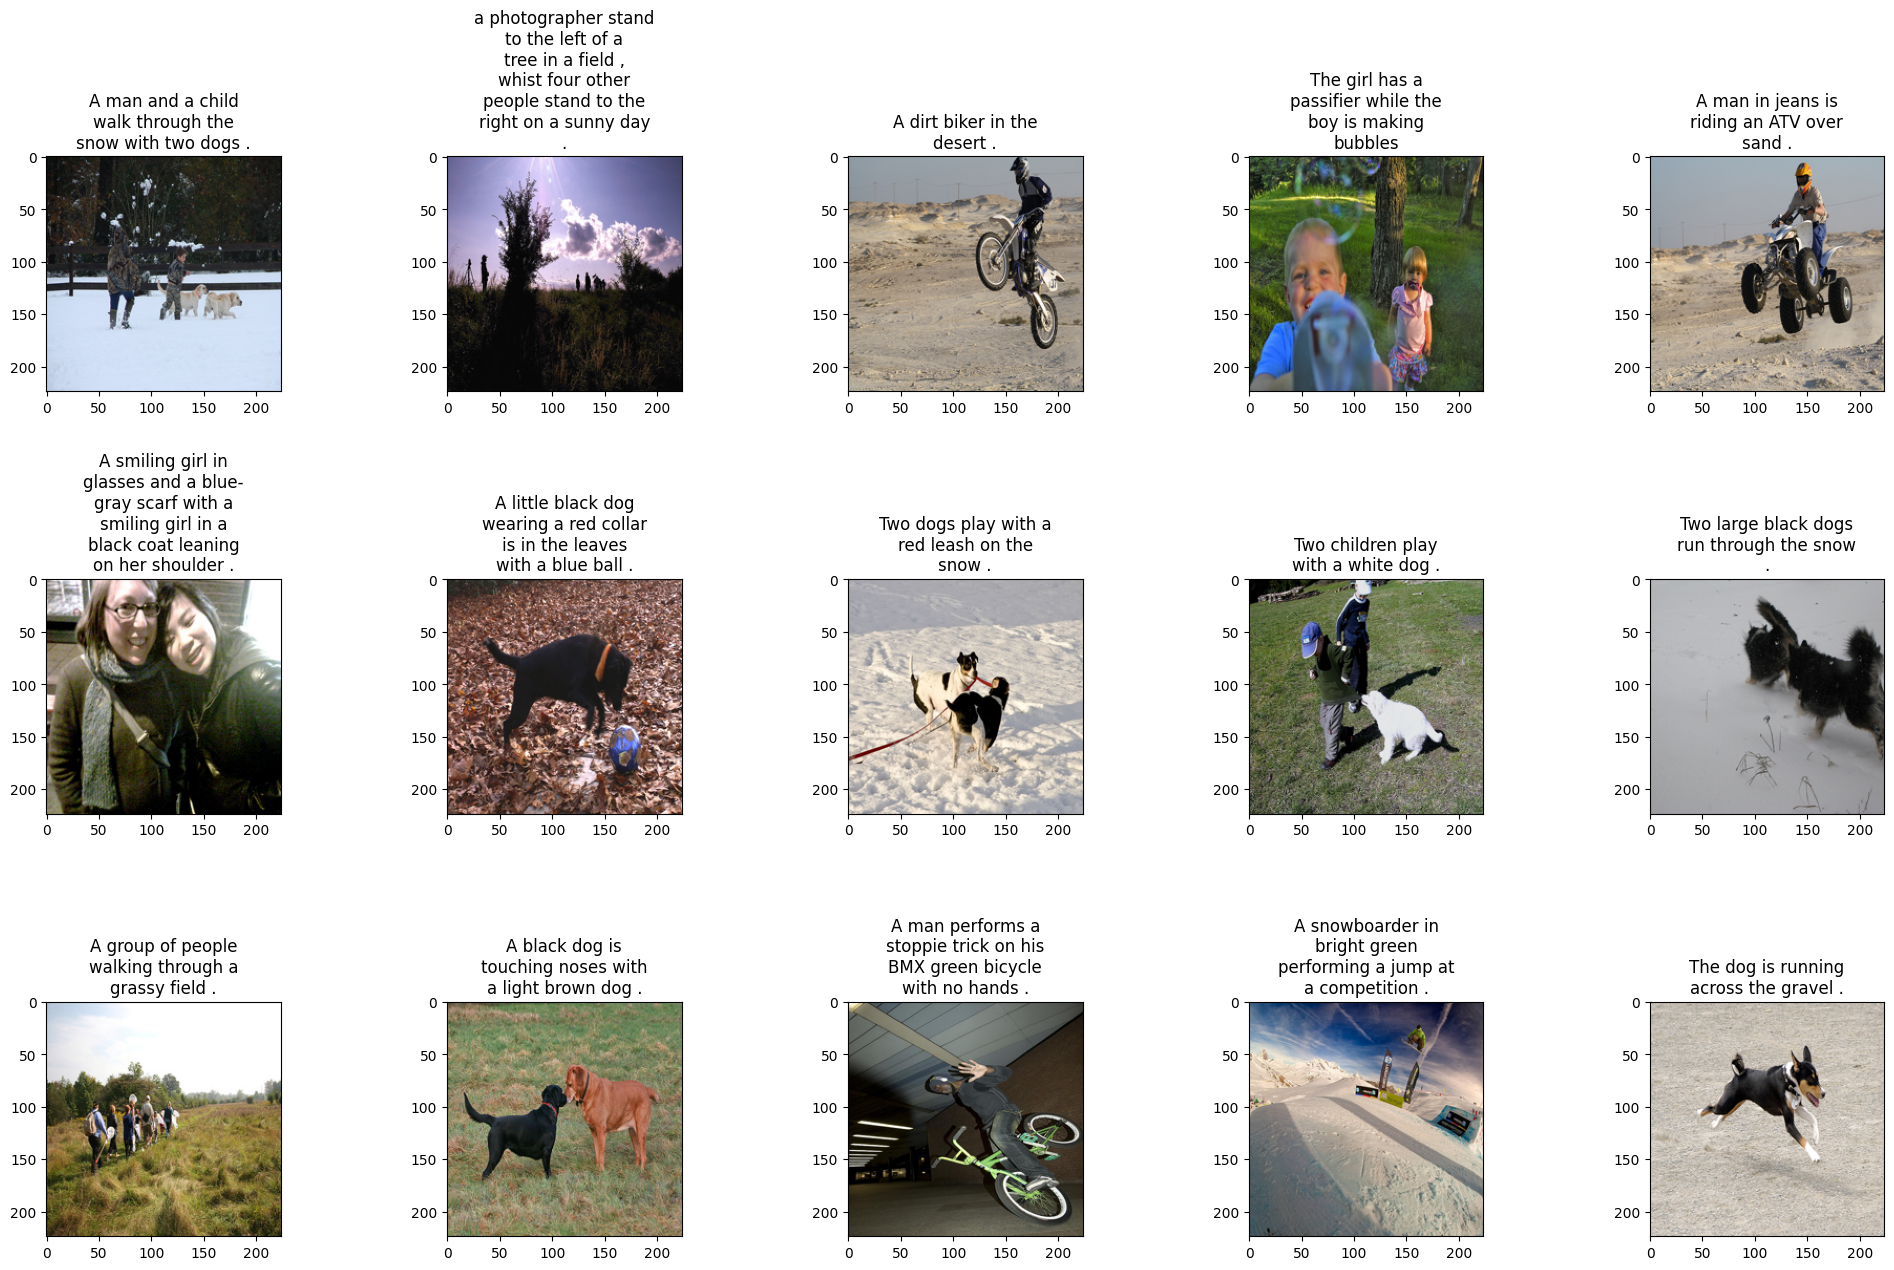

In [10]:
show_images(15, images)

### 1.2 Analysing datasets
- Images
- Captions

In [13]:
# images dataset
total_width = total_height = 0

for filename in images:
    try:
        if os.path.splitext(filename)[1].lower() not in valid_imgExt:
            continue
        with open(os.path.join(image_path, filename), 'rb') as file:
            img = Image.open(file)
            width, height = img.size

            total_width += width
            total_height += height
            img.close()
    except Exception as e:
        print(f"Skipping {filename} due to error: {e}")

average_width = total_width / len(images)
average_height = total_height / len(images)

print(f"Average Width: {average_width:.4f}")
print(f"Average Height: {average_height:.4f}")

Average Width: 457.8722
Average Height: 397.2519


In [15]:
# captions dataset
display(captions.head(10))
print("We observe that there are multiple captions for each image.")

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


We observe that there are multiple captions for each image.


### 2.1 Clean captions dataset

- Convert all char to lowercase
- Remove unncecessary white spaces
- Only allow valid char in the English language
- Remove special char eg. '&', '*', '(', ')', etc

In [16]:
def text_preprocessing(df):
    df['caption'] = df['caption'].str.lower()
    df['caption'] = df['caption'].str.replace("[^A-Za-z]", " ", regex=True)
    df['caption'] = df['caption'].str.replace("\s+", " ", regex=True)
    df['caption'] = df['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    df['caption'] = "Sseq " + df['caption'] + " Eseq"
    return df

captions_clean = captions.copy()
captions_clean = text_preprocessing(captions_clean)
captions_list = captions_clean['caption'].tolist()
captions_list[:10]

['Sseq child in pink dress is climbing up set of stairs in an entry way Eseq',
 'Sseq girl going into wooden building Eseq',
 'Sseq little girl climbing into wooden playhouse Eseq',
 'Sseq little girl climbing the stairs to her playhouse Eseq',
 'Sseq little girl in pink dress going into wooden cabin Eseq',
 'Sseq black dog and spotted dog are fighting Eseq',
 'Sseq black dog and tri colored dog playing with each other on the road Eseq',
 'Sseq black dog and white dog with brown spots are staring at each other in the street Eseq',
 'Sseq two dogs of different breeds looking at each other on the road Eseq',
 'Sseq two dogs on pavement moving toward each other Eseq']

In [18]:
# Creating a descriptions{} to group captions with their respective filename
descriptions = {}

for index, row in captions_clean.iterrows():
    image_name = row['image']
    comment = row['caption']
    
    # If image_name is not in the dictionary, create a new entry
    if image_name not in descriptions:
        descriptions[image_name] = [comment]
    else:
        # If image_name is already in the dictionary, append the comment to the existing list
        descriptions[image_name].append(comment)

descriptions

{'1000268201_693b08cb0e.jpg': ['Sseq child in pink dress is climbing up set of stairs in an entry way Eseq',
  'Sseq girl going into wooden building Eseq',
  'Sseq little girl climbing into wooden playhouse Eseq',
  'Sseq little girl climbing the stairs to her playhouse Eseq',
  'Sseq little girl in pink dress going into wooden cabin Eseq'],
 '1001773457_577c3a7d70.jpg': ['Sseq black dog and spotted dog are fighting Eseq',
  'Sseq black dog and tri colored dog playing with each other on the road Eseq',
  'Sseq black dog and white dog with brown spots are staring at each other in the street Eseq',
  'Sseq two dogs of different breeds looking at each other on the road Eseq',
  'Sseq two dogs on pavement moving toward each other Eseq'],
 '1002674143_1b742ab4b8.jpg': ['Sseq little girl covered in paint sits in front of painted rainbow with her hands in bowl Eseq',
  'Sseq little girl is sitting in front of large painted rainbow Eseq',
  'Sseq small girl in the grass plays with fingerpaints

### 2.2 Tokenise captions dataset

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions_list)
vocab_size = len(tokenizer.word_index) + 1
max_length = 0
for captions in captions_clean['caption']:
    if len(captions.split()) > max_length:
        max_length = len(captions.split())
print(f"max_length of sequence: {max_length}")

images = captions_clean['image'].unique().tolist()

# 85% training, 15% validation
split_index = round(0.85*len(images))
train_images = images[:split_index]
val_images = images[split_index:]

train = captions_clean[captions_clean['image'].isin(train_images)]
test = captions_clean[captions_clean['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions_list[1]])[0]

max_length of sequence: 35


[1, 18, 313, 63, 194, 116, 2]

### 2.3 Data Generator

In [11]:
# def data_generator(descriptions, features, tokenizer, max_length):
#     while 1:
#         for filename, description_list in descriptions.items():
#             #retrieve photo features
#             feature = features[filename][0]
#             inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
#             yield [[inp_image, inp_seq], op_word]

# def create_sequences(tokenizer, max_length, desc_list, feature):
#     x_1, x_2, y = list(), list(), list()
#     # move through each description for the image
#     for desc in desc_list:
#         # encode the sequence
#         seq = tokenizer.texts_to_sequences([desc])[0]
#         # divide one sequence into various X,y pairs
#         for i in range(1, len(seq)):
#             # divide into input and output pair
#             in_seq, out_seq = seq[:i], seq[i]
#             # pad input sequence
#             in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
#             # encode output sequence
#             out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
#             # store
#             x_1.append(feature)
#             x_2.append(in_seq)
#             y.append(out_seq)

#     return np.array(x_1), np.array(x_2), np.array(y)

In [21]:
def data_generator(descriptions, features, tokenizer, max_length, vocab_size, batch_size, shuffle=True):
    while True:  # Loop forever so the generator never terminates
        keys = list(descriptions.keys())
        if shuffle:
            np.random.shuffle(keys)
        
        # Loop over the image identifiers in the descriptions
        for i in range(0, len(keys), batch_size):
            batch_keys = keys[i:i+batch_size]
            inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, vocab_size, descriptions, features, batch_keys)
            yield [[np.array(inp_image), np.array(inp_seq)], np.array(op_word)]

def create_sequences(tokenizer, max_length, vocab_size, descriptions, features, batch_keys):
    x_1, x_2, y = [], [], []
    # Loop over each image identifier in the batch
    for key in batch_keys:
        # Retrieve the photo feature
        feature = features[key][0]
        # Get all descriptions for the image
        desc_list = descriptions[key]
        for desc in desc_list:
            # Encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # Split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # Split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # Pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # Encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # Store
                x_1.append(feature)
                x_2.append(in_seq)
                y.append(out_seq)
    return x_1, x_2, y

### 3.1 Define pretrained CNN models for image feature extraction

In [22]:
model1, model2, model3, model4 = VGG16(), DenseNet201(), InceptionV3(), ResNet50()

### 3.1.1 Feature extraction

In [23]:
features1 = features2 = features3 = features4 = {}

feature_ex1 = Model(inputs=model1.input, outputs=model1.layers[-2].output)
feature_ex2 = Model(inputs=model2.input, outputs=model2.layers[-2].output)
feature_ex3 = Model(inputs=model3.input, outputs=model3.layers[-2].output)
feature_ex4 = Model(inputs=model4.input, outputs=model4.layers[-2].output)

def feature_extraction(feature_ex, images, features):
    for filename in tqdm(images):
        try:
            if os.path.splitext(filename)[1].lower() not in valid_imgExt:
                continue
            with open(os.path.join(image_path, filename), 'rb') as img:
                img = Image.open(img).resize(image_size[2])
                img = img_to_array(img)
                # Normalise image pixel values [0,255] -> [0,1]
                img = img/255
                img = np.expand_dims(img, axis=0)
                feature = feature_ex(img)
                features[filename] = feature
        except Exception as e:
            print(f"Skipping {filename} due to error: {e}")

In [24]:
# model1 VGG16
feature_extraction(feature_ex1, images, features1)

with open('./fe_dict_save/features1_8k.pkl', 'wb') as file:
    pickle.dump(features1, file)
with open('./fe_dict_save/features1_8k.pkl', 'rb') as file:
    features1 = pickle.load(file)

 60%|██████    | 4865/8091 [16:09<15:36,  3.45it/s]

In [15]:
# model2 DenseNet201
#feature_extraction(feature_ex2, images, features2)

#with open('./fe_dict_save/features2.pkl', 'wb') as file:
#    pickle.dump(features2, file)
with open('./fe_dict_save/features2.pkl', 'rb') as file:
    features2 = pickle.load(file)

In [16]:
# model3 InceptionV3
# feature_extraction(feature_ex3, images, features3)

# with open('./fe_dict_save/features3.pkl', 'wb') as file:
#     pickle.dump(features3, file)
# with open('./fe_dict_save/features3.pkl', 'rb') as file:
#     features3 = pickle.load(file)
# # input 0 of layer 'model_2' is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(1, 224, 22

In [17]:
# model4 ResNet50
#feature_extraction(feature_ex4, images, features1)

#with open('./fe_dict_save/features4.pkl', 'wb') as file:
#    pickle.dump(features4, file)
with open('./fe_dict_save/features4.pkl', 'rb') as file:
    features4 = pickle.load(file)

### 3.2 Define the network (CNN + LSTM)

In [19]:
input1 = Input(shape=(4096,))
input2 = Input(shape=(max_length,))

img_features_1 = Dropout(0.4)(input1)
img_features_2 = Dense(256, activation='relu')(img_features_1)

sentence_features_1 = Embedding(vocab_size, 256, mask_zero=False)(input2)
sentence_features_2 = Dropout(0.4)(sentence_features_1)
sentence_features_3 = LSTM(256)(sentence_features_2)

merged = concatenate([img_features_2, sentence_features_3], axis=1)
decoder = Dense(256, activation = 'relu')(merged)
output = Dense(vocab_size, activation='softmax')(decoder)

model = Model(inputs=[input1, input2], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()
plot_model(model)

# input1 = Input(shape=(2048,))
# input2 = Input(shape=(max_length,))

# # Applying L2 regularization to the Dense layer
# img_features = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(input1)
# img_features_reshaped = Reshape((1, 256))(img_features)

# sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

# # Concatenate image and sentence features
# merged = concatenate([img_features_reshaped, sentence_features], axis=1)

# # Adding an additional LSTM layer and applying L2 regularization
# sentence_features = LSTM(256, return_sequences=True, kernel_regularizer=l2(0.01))(merged)
# sentence_features = LSTM(256, kernel_regularizer=l2(0.01))(sentence_features)

# # Or, alternatively, using a Bidirectional LSTM layer
# # sentence_features = Bidirectional(LSTM(256, kernel_regularizer=l2(0.01)))(merged)

# x = Dropout(0.5)(sentence_features)
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = Dropout(0.5)(x)
# output = Dense(vocab_size, activation='softmax')(x)

# model = Model(inputs=[input1, input2], outputs=output)
# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# model.summary()
# plot_model(model, show_shapes=True)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 74)]                 0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 74, 256)              4622592   ['input_8[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 4096)                 0         ['input_7[0][0]']             
                                                                                            

In [20]:
# Split the descriptions into training and validation sets
train_descriptions = {k: v for k, v in descriptions.items() if k in train_images}
val_descriptions = {k: v for k, v in descriptions.items() if k in val_images}

batch_size = 64
num_epochs = 50

train_generator1 = data_generator(train_descriptions, features1, tokenizer, max_length, vocab_size, batch_size)
val_generator1 = data_generator(val_descriptions, features1, tokenizer, max_length, vocab_size, batch_size)

# Implement early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [21]:
hist = model.fit(
    train_generator1,
    steps_per_epoch=len(train_descriptions)//batch_size,
    epochs=num_epochs,
    validation_data=val_generator1,
    validation_steps=len(val_descriptions)//batch_size,
    verbose=1,
    callbacks=[early_stop, lr_scheduler],
    batch_size=batch_size
)

Epoch 1/50
 49/422 [==>...........................] - ETA: 61:54:13 - loss: 6.4881 - accuracy: 0.0722

In [220]:
model.save('model.h5')

/Users/chufeng/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
model = load_model('model.h5')
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_63 (InputLayer)       [(None, 2048)]               0         []                            
                                                                                                  
 dense_53 (Dense)            (None, 256)                  524544    ['input_63[0][0]']            
                                                                                                  
 input_64 (InputLayer)       [(None, 74)]                 0         []                            
                                                                                                  
 reshape_30 (Reshape)        (None, 1, 256)               0         ['dense_53[0][0]']            
                                                                                           

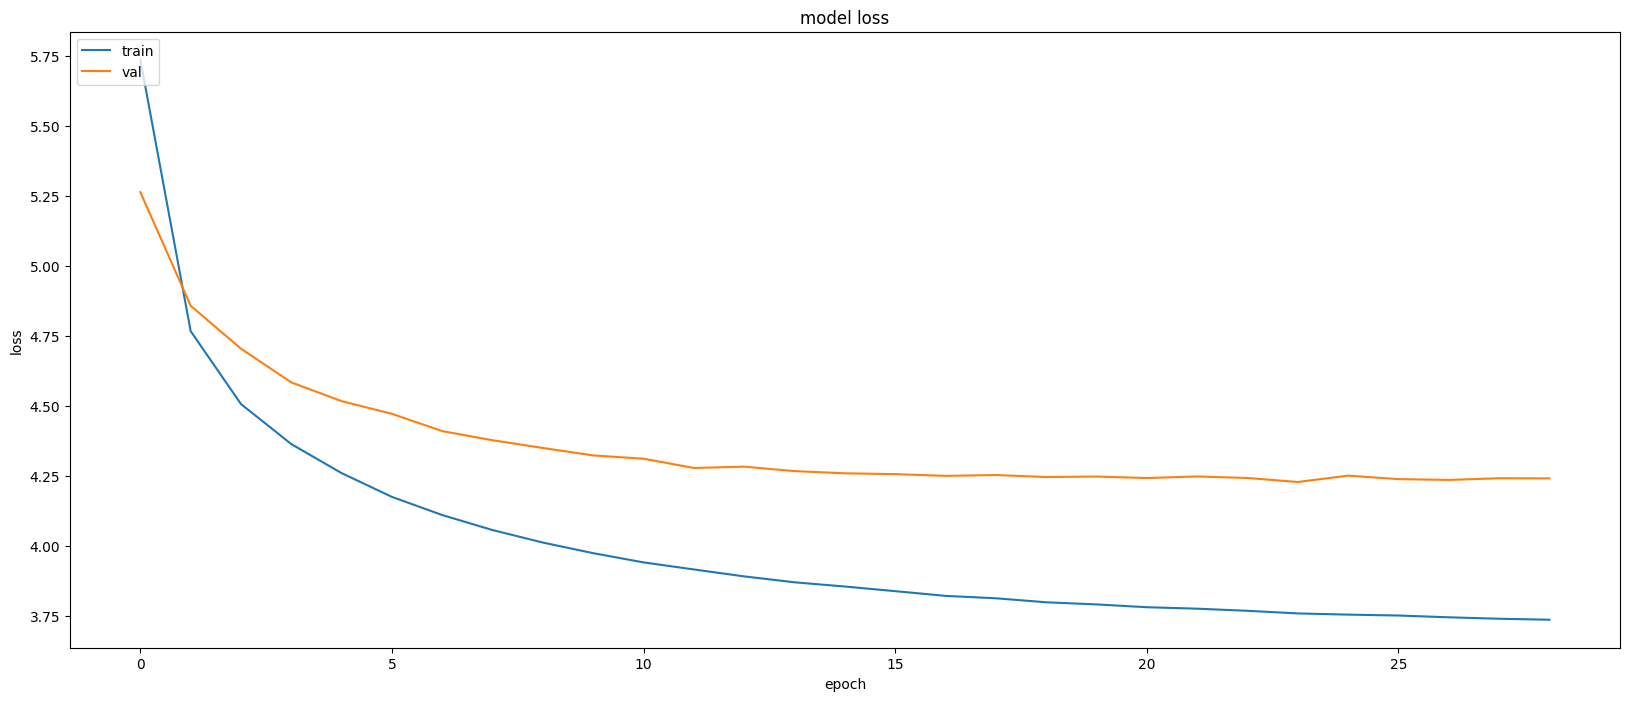

In [215]:
plt.figure(figsize=(20,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

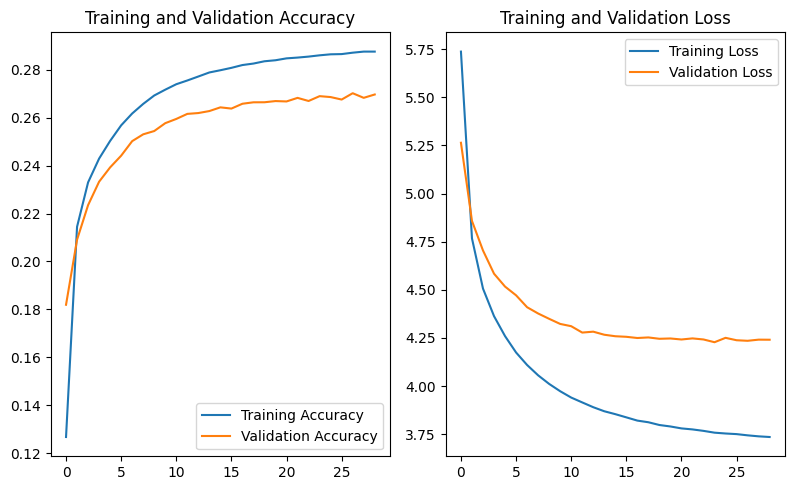

In [216]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [43]:
def generate_caption(model, image_feature, tokenizer, max_length):
    # Start the sequence with the start token
    in_text = 'Sseq'
    for i in range(max_length):
        # Convert the text input to integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Predict the next word
        yhat = model.predict([image_feature, sequence], verbose=0)
        # Convert the probability to integer
        yhat = np.argmax(yhat)
        # Map integer to word
        word = word_for_id(yhat, tokenizer)
        # Break if we reach the end of the sequence
        if word == 'Eseq':
            break
        # Append the word to the sequence
        in_text += ' ' + word
    # Remove the start token before returning the caption
    final_caption = in_text.split(' ', 1)[1]
    return final_caption


def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [48]:
# Make sure to use the seed function for reproducibility if needed
# random.seed(your_seed)

# Select 15 random images
random_images = random.sample(images, 15)

# Retrieve corresponding features for the selected images
selected_features = {image_name: features2[image_name] for image_name in random_images if image_name in features2}

# Generate and print captions for the selected images
for image_name, feature in selected_features.items():
    # Since features are stored in a dict with keys as filenames and values as extracted features,
    # we need to get the features in the correct shape
    feature = np.array(feature).reshape((1, 2048))

    # Generate the caption
    caption = generate_caption(model, feature, tokenizer, max_length)
    
    # Print out the image name and its generated caption
    print(f'Image: {image_name}')
    print(f'Caption: {caption}')
    print('---')


ValueError: cannot reshape array of size 4096 into shape (1,2048)

### 3.3 Train the model using different CNN models

### 3.3.1 VGG16

### 3.3.2 DenseNet201

### 3.3.3 InceptionV3

### 3.3.4 ResNet50

### 3.4 Evaluate CNN models

### 4.1